In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


In [35]:
df = pd.read_csv("../data/processed.csv", index_col=0)

In [36]:
df.head()

,movie_id,title,release_date,budget,revenue_worldwide,runtime,genres,imdb_id,franchise,cast_popularity_mean,...,imdb_votes,mpaa_rating,domestic_box_office,rotten_tomatoes_score,metacritic_score,awards_text,month,season,critics_score,audience_score
0,983044,The Arctic Convoy,2023-12-25,0.013472,0.001759,0.186325,"['War', 'Drama']",tt27724113,False,0.057893,...,0.001341,NaN,0.000003,1.00,NaN,3 wins & 6 nominations total,12,Winter,1.000000,0.666667
1,851976,Small World,2021-09-10,0.000000,0.000000,0.200000,"['Crime', 'Action', 'Drama']",tt14319068,False,0.071943,...,0.000265,NaN,NaN,NaN,NaN,1 win,9,Other,NaN,0.551282
2,12,Finding Nemo,2003-05-30,0.191876,0.454659,0.170940,"['Animation', 'Family']",tt0266543,True,0.113672,...,0.381986,G,0.406596,0.99,0.913043,Won 1 Oscar. 49 wins & 63 nominations total,5,Other,0.951522,0.884615
3,16,Dancer in the Dark,2000-09-01,0.025515,0.019370,0.239316,"['Drama', 'Crime']",tt0168629,False,0.133430,...,0.039417,R,0.004466,0.69,0.619565,Nominated for 1 Oscar. 34 wins & 48 nomination...,9,Other,0.654783,0.846154
4,17,The Dark,2005-09-28,0.000000,0.003188,0.148718,"['Horror', 'Thriller', 'Mystery']",tt0411267,False,0.196721,...,0.003769,R,NaN,0.40,NaN,1 nomination total,9,Other,0.400000,0.512821


In [37]:
df.columns

Index(['movie_id', 'title', 'release_date', 'budget', 'revenue_worldwide',
       'runtime', 'genres', 'imdb_id', 'franchise', 'cast_popularity_mean',
       'cast_popularity_max', 'director_popularity', 'original_language',
       'imdb_rating', 'imdb_votes', 'mpaa_rating', 'domestic_box_office',
       'rotten_tomatoes_score', 'metacritic_score', 'awards_text', 'month',
       'season', 'critics_score', 'audience_score'],
      dtype='object')

In [38]:
df.dtypes

movie_id                   int64
title                     object
release_date              object
budget                   float64
revenue_worldwide        float64
runtime                  float64
genres                    object
imdb_id                   object
franchise                   bool
cast_popularity_mean     float64
cast_popularity_max      float64
director_popularity      float64
original_language         object
imdb_rating              float64
imdb_votes               float64
mpaa_rating               object
domestic_box_office      float64
rotten_tomatoes_score    float64
metacritic_score         float64
awards_text               object
month                      int64
season                    object
critics_score            float64
audience_score           float64
dtype: object

In [39]:
features = df[['critics_score','audience_score','genres']].copy()

features = features.dropna(subset=['critics_score','audience_score'])

import ast
features['genres'] = features['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)


In [40]:
features["genres"]

0                               [War, Drama]
2                        [Animation, Family]
3                             [Drama, Crime]
4                [Horror, Thriller, Mystery]
5                           [Drama, Romance]
                        ...                 
10754                     [Thriller, Horror]
10755               [Thriller, Drama, Crime]
10756     [Drama, Animation, Family, Comedy]
10757    [Mystery, Romance, Science Fiction]
10758              [Drama, Romance, History]
Name: genres, Length: 1522, dtype: object

In [41]:
X = features[['critics_score','audience_score']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [42]:
X_scaled

array([[ 1.77743861, -0.15391426],
       [ 1.55904078,  1.58892055],
       [ 0.22221103,  1.28136146],
       ...,
       [ 0.90972348,  0.46120391],
       [-0.84921149,  0.25616452],
       [-0.76400696,  0.6662433 ]], shape=(1522, 2))

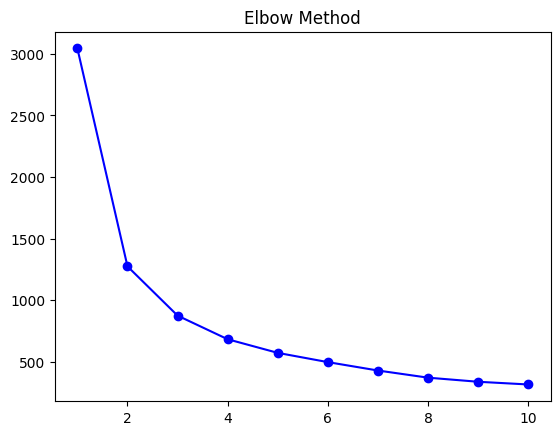

In [43]:
inertia = []
K_range = range(1,11)
K_range = range(1,11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(K_range, inertia, 'bo-')
plt.title('Elbow Method')
plt.show()

In [44]:
kmeans = KMeans(n_clusters=5, random_state=42)
features['cluster'] = kmeans.fit_predict(X_scaled)

cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("Cluster centers (critics_score, audience_score):")
print(cluster_centers)


Cluster centers (critics_score, audience_score):
[[0.69759798 0.63353196]
 [0.24871714 0.4643709 ]
 [0.40455795 0.62956217]
 [0.6326867  0.75372689]
 [0.84959306 0.81596564]]


In [45]:
cluster_names = []
print(" Analyzing 4 Clusters ")

for i, c in enumerate(cluster_centers):
    critics_val = c[0]
    audience_val = c[1] * 10

    diff = audience_val - critics_val
    avg = (critics_val + audience_val) / 2

    name = ""


    if avg < 5.0:
        name = 'Consensus: Poor Quality'

    elif diff > 1.0:
        name = 'Divergence: Audience Preferred'

    elif diff < -1.0:
        name = 'Divergence: Critics Preferred'

    elif avg > 7.5:
        name = 'Consensus: High Quality'

    else:
        name = 'Consensus: Average'

    cluster_names.append(name)
    print(f"Cluster {i}: Crit={critics_val:.1f}, Aud={audience_val:.1f}, Diff={diff:.1f} -> {name}")

cluster_map = {i:name for i,name in enumerate(cluster_names)}
features['cluster_name'] = features['cluster'].map(cluster_map)


 Analyzing 4 Clusters 
Cluster 0: Crit=0.7, Aud=6.3, Diff=5.6 -> Consensus: Poor Quality
Cluster 1: Crit=0.2, Aud=4.6, Diff=4.4 -> Consensus: Poor Quality
Cluster 2: Crit=0.4, Aud=6.3, Diff=5.9 -> Consensus: Poor Quality
Cluster 3: Crit=0.6, Aud=7.5, Diff=6.9 -> Consensus: Poor Quality
Cluster 4: Crit=0.8, Aud=8.2, Diff=7.3 -> Consensus: Poor Quality


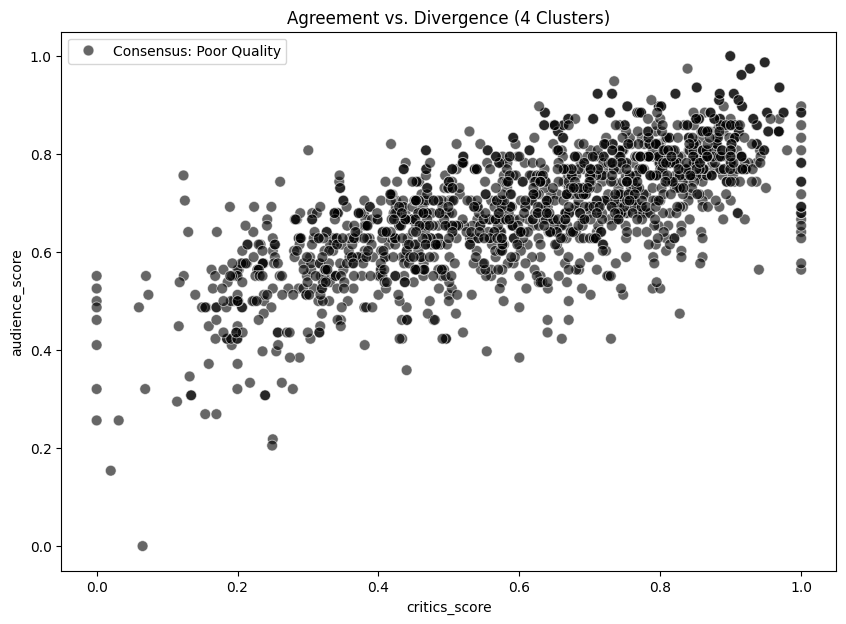

In [46]:
colors = {
    'Consensus: High Quality': 'blue',
    'Consensus: Poor Quality': 'black',
    'Divergence: Audience Preferred': 'green',
    'Divergence: Critics Preferred': 'red',
    'Consensus: Average': 'gray'
}

plt.figure(figsize=(10,7))
sns.scatterplot(
    x='critics_score', y='audience_score',
    hue='cluster_name', palette=colors,
    data=features, alpha=0.6, s=60
)
plt.title('Agreement vs. Divergence (4 Clusters)')
plt.legend()
plt.show()

In [47]:
features_exploded = features.explode('genres') 

genre_cluster_distribution = (
    features_exploded.groupby(['genres', 'cluster_name'])
    .size()
    .unstack(fill_value=0)
)

In [48]:
genre_cluster_distribution = (
    features_exploded.groupby(['genres', 'cluster_name'])
    .size()
    .unstack(fill_value=0)
)


In [49]:
genre_cluster_distribution['total'] = genre_cluster_distribution.sum(axis=1)

expected_cols = [
    'Consensus: High Quality',
    'Consensus: Poor Quality',
    'Divergence: Audience Preferred',
    'Divergence: Critics Preferred',
    'Consensus: Average'
]

for col in expected_cols:
    if col in genre_cluster_distribution.columns:
        genre_cluster_distribution[col+'_pct'] = (genre_cluster_distribution[col] / genre_cluster_distribution['total']) * 100
    else:
        genre_cluster_distribution[col+'_pct'] = 0

print(genre_cluster_distribution.head())

cluster_name  Consensus: Poor Quality  total  Consensus: High Quality_pct  \
genres                                                                      
Action                            425    425                            0   
Adventure                         333    333                            0   
Animation                         125    125                            0   
Comedy                            424    424                            0   
Crime                             247    247                            0   

cluster_name  Consensus: Poor Quality_pct  Divergence: Audience Preferred_pct  \
genres                                                                          
Action                              100.0                                   0   
Adventure                           100.0                                   0   
Animation                           100.0                                   0   
Comedy                              100.0              

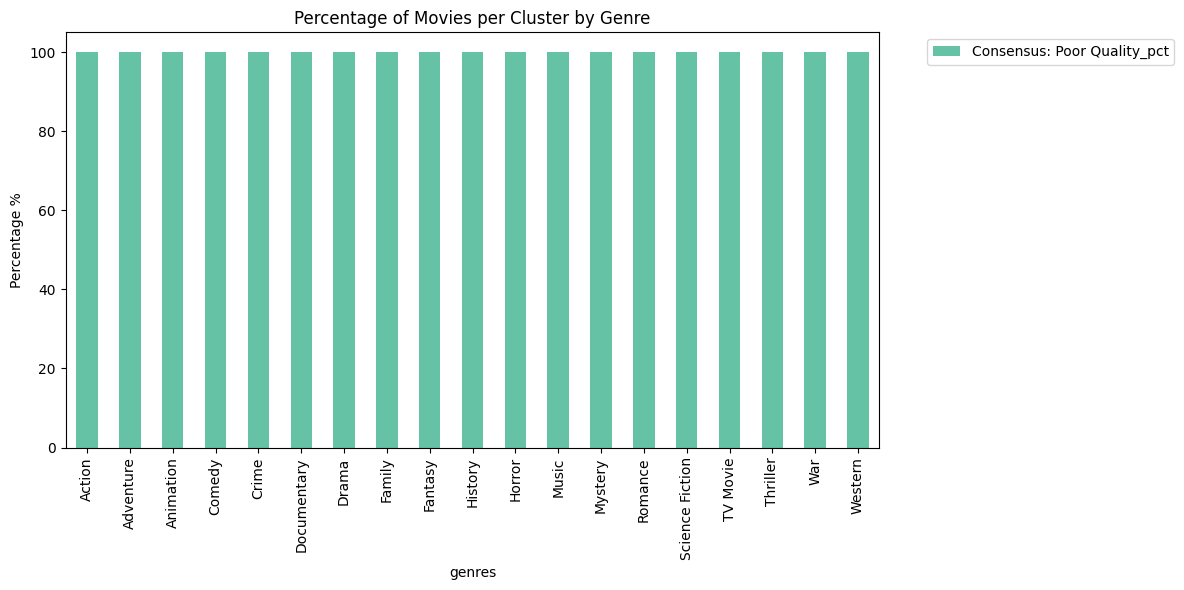

In [50]:
cols_to_plot = [c+'_pct' for c in expected_cols if c in genre_cluster_distribution.columns]

genre_cluster_distribution[cols_to_plot].plot(
    kind='bar',
    stacked=True,
    figsize=(12,6),
    colormap='Set2'  
)

plt.title('Percentage of Movies per Cluster by Genre')
plt.ylabel('Percentage %')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [51]:
r2_critics = r2_score(features['critics_score'], cluster_centers[features['cluster'],0])
r2_audience = r2_score(features['audience_score'], cluster_centers[features['cluster'],1])

print(f"R² for critics_score: {r2_critics:.3f}")
print(f"R² for audience_score: {r2_audience:.3f}")


R² for critics_score: 0.843
R² for audience_score: 0.782
